In [77]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ParseData
import scipy.stats as stats
import numpy as np

import importlib
importlib.reload(ParseData)


Data = ParseData.GetData()

Total Police Killings in Canada: Jan 2000 - June 2020: 586
49
DATE
2000-01-01    19
2001-01-01    15
2002-01-01    14
2003-01-01    15
2004-01-01    27
2005-01-01    31
2006-01-01    22
2007-01-01    28
2008-01-01    25
2009-01-01    25
2010-01-01    29
2011-01-01    29
2012-01-01    23
2013-01-01    24
2014-01-01    24
2015-01-01    36
2016-01-01    40
2017-01-01    34
2018-01-01    32
2019-01-01    34
2020-01-01    30
Freq: AS-JAN, Name: PROV, dtype: int64
DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01'],
              dtype='datetime64[ns]', name='DATE', freq='AS-JAN') [22 15 14 15 28 31 22 28 25 25 29 29 24 24 24 36 40 34 32 37 49  3]
Linr

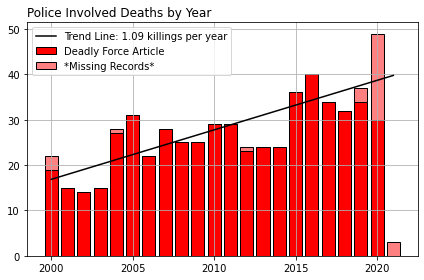

In [82]:
CA_Total=Data.CA_PoliceKillings['PROV'].count()
print('Total Police Killings in Canada: Jan 2000 - June 2020: '+str(CA_Total.sum()))
ByYear=Data.CA_PoliceKillings.resample('YS').count()['PROV']


print(ByYear.max())

CBC_Article = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']=='CBC Deadly Force'].resample('YS').count()['PROV']
Missing = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force'].resample('YS').count()['PROV']
print(CBC_Article)

print(ByYear.index,ByYear.values)

LR = stats.linregress(ByYear.index.year[:-1],ByYear.values[:-1])
print(LR)


fig,ax=plt.subplots(1,1)
ax.set_title('Police Involved Deaths by Year',loc='left')
ax.bar(CBC_Article.index.year,CBC_Article.values,
       color=[1,0,0],edgecolor='k',label='Deadly Force Article')
ax.bar(Missing.index.year,Missing.values,bottom = np.append(CBC_Article.values,[0]),
       color=[1,0.5,0.5],edgecolor='k',label='*Missing Records*')
# ax.bar([2020],[ByYear.values[-1]],color=[1,.5,.5],edgecolor='k',label='Total Jan-Nov')
ax.plot(ByYear.index.year,ByYear.index.year*LR[0]+LR[1],
        color='k',label = 'Trend Line: '+str(np.round(LR[0],2))+' killings per year')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_Trendline.png')

In [81]:
print(Data.CA_PoliceKillings.index)
print(Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['PROV']=='QC'].resample('Y').count()['VICTIM ID'])

DatetimeIndex(['2000-01-01', '2000-01-07', '2000-01-30', '2000-04-07',
               '2000-04-11', '2000-05-31', '2000-06-02', '2000-07-16',
               '2000-07-17', '2000-07-18',
               ...
               '2020-10-13', '2020-10-30', '2020-11-19', '2020-11-26',
               '2020-11-26', '2020-12-05', '2020-12-08', '2021-01-05',
               '2021-02-23', '2021-02-27'],
              dtype='datetime64[ns]', name='DATE', length=586, freq=None)
DATE
2000-12-31     3
2001-12-31     0
2002-12-31     2
2003-12-31     2
2004-12-31     5
2005-12-31     4
2006-12-31     1
2007-12-31     7
2008-12-31     3
2009-12-31     3
2010-12-31     5
2011-12-31     8
2012-12-31     4
2013-12-31     4
2014-12-31     4
2015-12-31     5
2016-12-31    14
2017-12-31    13
2018-12-31     3
2019-12-31     3
2020-12-31     9
Freq: A-DEC, Name: VICTIM ID, dtype: int64


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

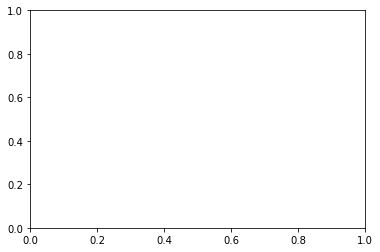

https://bccla.org/wp-content/uploads/2012/03/2012-BCCLA-Report-Police-Involved-Deaths3.pdf